In [1]:
from sklearn.cluster import *
import scipy
import copy
import numpy as np
from matplotlib import pyplot as plt
from Bio import AlignIO
import pickle
import h5py
import dendropy
#todo. blur mat up and down tree
#todo. group codons 
#

(72513, 45950)


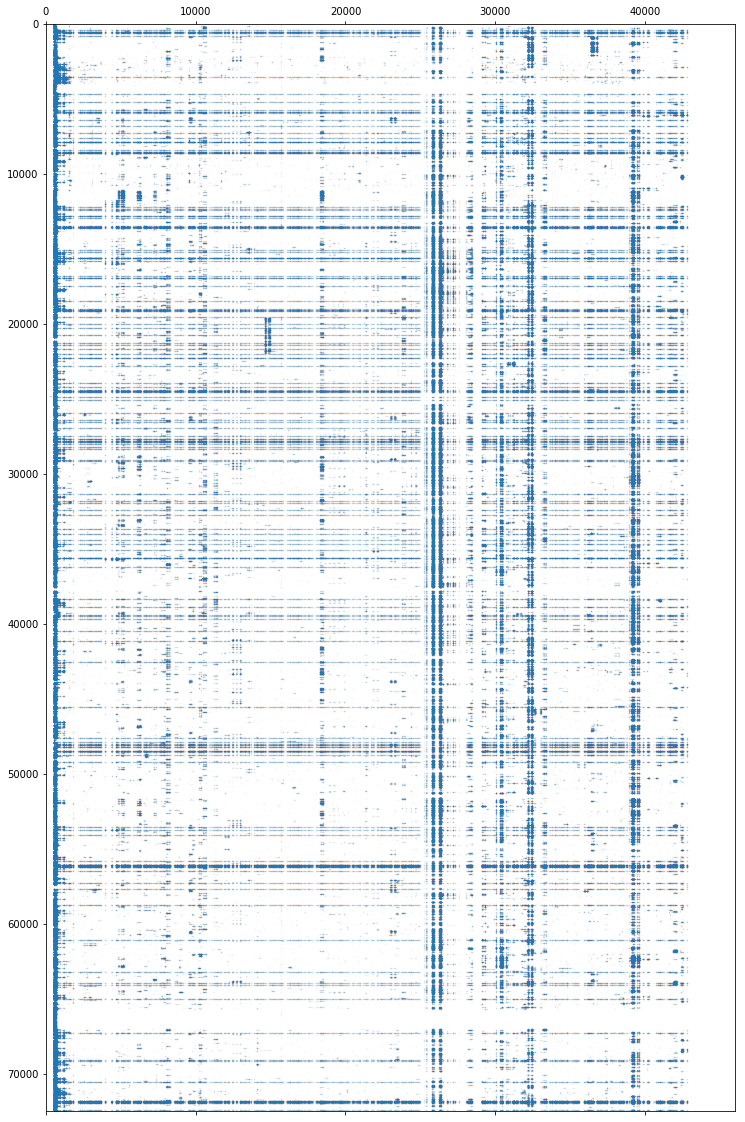

In [2]:
#load sankoff coev mat
with open( './coevmat.pkl' , 'rb') as matin:
    coevmat = pickle.loads(matin.read())
print(coevmat.shape)
plt.figure( figsize=(30,20))
plt.spy(coevmat, markersize= .01)

In [3]:
#create the connectivity mat and use it to blur the coev mat
tree = dendropy.Tree.get(
    path='./lanford/ft_TBE.tree.txt',
    schema='newick')
for l in tree.leaf_nodes()[0:10]:
    print(str(l.taxon))
print(len(tree.leaf_nodes()))
print('leaves')


for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None
    if i< 10:
        print(n)
        print(n.matrow)

            
matsize = len(tree.nodes())
print(matsize)
print('nodes')



'hCoV-19/Wuhan/WH04/2020|EPI ISL 406801|2020-01-05'
'hCoV-19/Xinyu/JX122/2020|EPI ISL 421249|2020-01-25'
'hCoV-19/Guangzhou/GZMU0046/2020|EPI ISL 429093|2020-02-08'
'hCoV-19/Wuhan/WHUH011/2020|EPI ISL 449484|2020-01-22'
'hCoV-19/Sichuan/SC-WCH3-255/2020|EPI ISL 451384|2020-01-27'
'hCoV-19/Guangzhou/GZMU0048/2020|EPI ISL 414691|2020-02-25'
'hCoV-19/Nanchang/JXN3T4/2020|EPI ISL 421246|2020-02-26'
'hCoV-19/Guangzhou/GZMU0078/2020|EPI ISL 457690|2020-02-11'
'hCoV-19/Ganzhou/JX81/2020|EPI ISL 421242|2020-01-25'
'hCoV-19/Shangrao/JX29/2020|EPI ISL 421244|2020-01-22'
36257
leaves
<Node object at 0x7f849c37a5f8: 'None' (None)>
0
<Node object at 0x7f849c37a668: 'None' (<Taxon 0x7f849c37a6d8 'hCoV-19/Wuhan/WH04/2020|EPI ISL 406801|2020-01-05'>)>
1
<Node object at 0x7f849c37a748: '0.010000' (None)>
2
<Node object at 0x7f849c37a7b8: 'None' (<Taxon 0x7f849c37a828 'hCoV-19/Xinyu/JX122/2020|EPI ISL 421249|2020-01-25'>)>
3
<Node object at 0x7f849c37a898: '0.025000' (None)>
4
<Node object at 0x7f849c37

In [74]:
import h5py
#calculate a distmat between cols w events
def distfun(v1,v2):
    #distance function between two continuous vectors
    #euclidean dist
    return np.linalg.norm( v1-v2 )
    
def process(q,retq, iolock):
    #calculate compression distances
    with iolock:
        print('init worker')
    from time import sleep
    while True:
        stuff = q.get()
        if stuff is None:
            break
        retq.put(distfun(stuff))
    print('done')

def mat_creator(retq,matsize,iolock):
    with iolock:
        print('init matcreator')
    #collect distances and create final mat
    calculations = (matsize**2 - matsize) / 2
    distmat = np.zeros((matsize,matsize))
    count = 0
    with h5py.File('./UKdata/alnEventdistmat.h5', 'a') as hf:
        try:
            hf.create_dataset("alnEventdists",  data=distmat)
        except:
            pass
        while True:
            r = retq.get()
            count+=1
            if r is None:
                break
            row,col,cdist = r
            hf['alnMI'][row,col] = cdist
            if count% 100000 == 0 :
                with iolock:
                    print(count/calculations)
                    print((row,col))
                    hf.flush()
    print('done saver')

startk = 0 
startl = 0

if __name__ == '__main__':
    NCORE = 64
    q = mp.Queue(maxsize=NCORE*5000)
    retq = mp.Queue(maxsize=NCORE*5000)
    iolock = mp.Lock()
    pool = mp.Pool(NCORE, initializer=process, initargs=(q,retq, iolock))
    p = mp.Process(target=mat_creator, args=(retq,len(msa[1,:]), iolock))
    p.start()
    
    for k,i in enumerate(informativesites):
        for l,j in enumerate(informativesites):
            if k < l and k> startk and l > startl :
                s1 = coevmat[:,i].ravel()
                s2 = coevmat[:,j].ravel()
                q.put( (i,j,s1,s2) )         
                if k % 100 == 0 and l %100 == 0:
                    print((k,l))
                    print((i,j))
    
    for _ in range(NCORE):  # tell workers we're done
        q.put(None)
    retq.put(None)
    pool.close()
    pool.join()
    p.join()
    
    
    

NameError: name 'mp' is not defined

In [ ]:
print(coevmat)
coevmat= coevmat[matrows,:]
plt.figure( figsize=(30,20))
plt.spy(coevmat, markersize= .01)

In [4]:

#blur w connectivity mat
blurfactor =  .5
bluriter = 4

connectmat = scipy.sparse.lil_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
connectmat[index[:,0],index[:,1]] = 1
connectmat+= connectmat.T

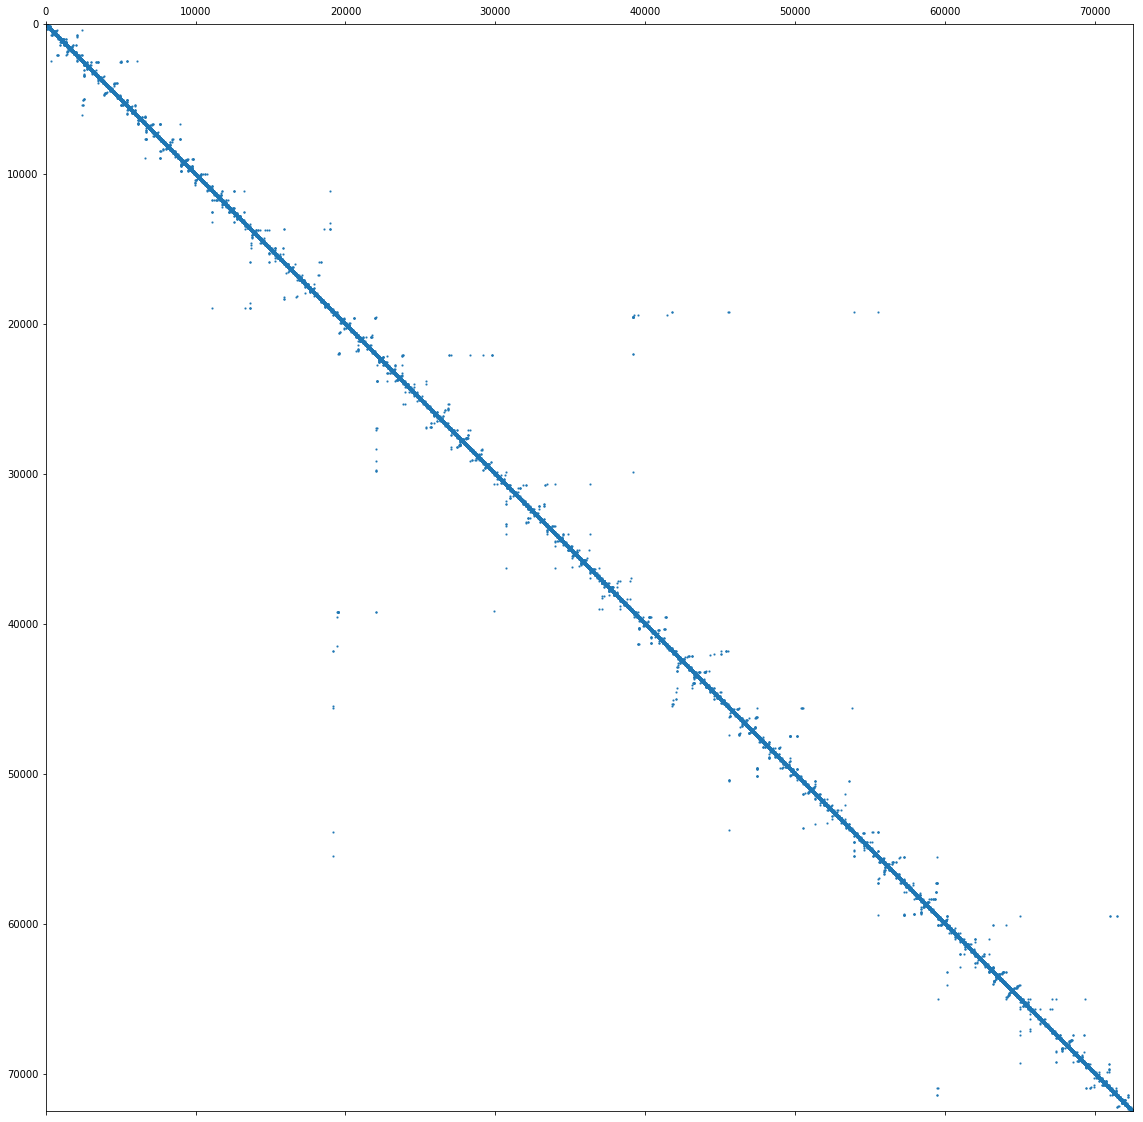

In [5]:
plt.figure( figsize=(20,20))
plt.spy(connectmat, markersize= 1)
plt.show()

In [6]:
#apply blur a few times
blurmat = copy.deepcopy(coevmat)
print(connectmat.shape)
print(blurmat.shape)
for i in range( bluriter):
    blurmat += np.dot(blurfactor*connectmat, blurmat)
    print('blurring')
    print(i)

(72513, 72513)
(72513, 45950)
blurring
0
blurring
1
blurring
2
blurring
3


In [9]:
with open('./gisaid/blurmat.pkl' , 'wb') as blurout:
    blurout.write( pickle.dumps(blurmat ))


In [10]:
with open('./gisaid/blurmat.pkl' , 'rb') as blurout:
    blurmat = pickle.loads( blurout.read())


In [ ]:
#cluster the informative columns evol events

ap = DBSCAN( eps = 2 , metric='euclidean', metric_params=None, algorithm='ball_tree', leaf_size=20, p=None, n_jobs=-1)
cluster_labels = ap.fit_predict(coevmat.T )

print(cluster_labels[1000:1200])
print(len(np.unique(cluster_labels)))

In [19]:
#cluster the informative columns evol events
apb = DBSCAN( eps = .2 , metric='euclidean', metric_params=None, algorithm='ball_tree', leaf_size=25, p=None, n_jobs=-1)
cluster_labelsb = apb.fit_predict(blurmat.T )
print(cluster_labelsb[1000:1200])

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/sklearn/neighbors/base.py:216: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1
 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1
 -1  0 -1  0 -1 -1 -1  0 -1  0  0 -1 -1 -1  0  0  0  0 -1 -1 -1  0 -1 -1
  0 -1 -1  0 -1 -1  0  0]


In [21]:
l,c = np.unique(cluster_labelsb, return_counts= True)
print(l)
print(c)

print(np.sum(c))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 6060 39472    20     5   269     5    13     6     5     5     5     5
    12     6     5    13     8     5     5     6     5     5     5     5]
45950


In [ ]:
plt.figure( figsize=(30,20))
for l in np.unique(cluster_labels):
    if len(cluster_labels[ cluster_labels==l ] ) < 200 and len(cluster_labels[ cluster_labels==l ] ) > 6:
        print(l)
        print( len(cluster_labels[ cluster_labels==l ] ) )
        mask =  scipy.sparse.lil_matrix(copy.deepcopy(blurmat))
        mask[:,  cluster_labels!=l ] = 0
        plt.spy(mask, markersize = 1 , )
plt.show()


In [ ]:
#order by tree depth
matrows = []
max_degree = max( [ n.level() for n in tree.leaf_nodes() ])
print(max_degree)

for i in range(max_degree):
    filter_fn = lambda n: hasattr(n, 'level') and n.level() == i
    nodes = tree.find_nodes(filter_fn=filter_fn)
    for n in nodes:
        matrows.append(n.matrow)
#reorder based on tree depth
print(matrows[0:100])
#filter by neighborhood branch support measure?



In [ ]:
#filter down to one sequence
#load aln
with h5py.File('./UKdata/aln.h5', 'r') as hf:
    align_array = hf['MSA2array'][:]
msa = AlignIO.read('./gisaid/msa_0612.lenfilter.fasta' , format = 'fasta')
def clipID(ID):
    return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
IDs = {i:clipID(rec.id) for i,rec in enumerate(msa)}
IDindex = dict(zip( IDs.values() , IDs.keys() ) )
print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )

In [ ]:
print(coevmat.shape)
print(submat_coev.shape)

In [ ]:
ap = DBSCAN( eps = 2 , metric='euclidean', metric_params=None, algorithm='ball_tree', leaf_size=20, p=None, n_jobs=-1)
cluster_labels = ap.fit_predict(submat_coev.T )


In [ ]:
import colour
crange = len(np.unique(cluster_labels))
red = colour.Color('red')
blue = colour.Color('blue')
colorhex = [ str(c.get_hex_l()) for c in red.range_to(blue, crange) ]
colorhex = dict(zip(np.unique(cluster_labels) , colorhex))

In [ ]:
plt.figure( figsize=(30,20))
for l in np.unique(cluster_labels):
    if len(cluster_labels[ cluster_labels==l ] ) < 200 and len(cluster_labels[ cluster_labels==l ] ) > 6:
        print(l)
        print( len(cluster_labels[ cluster_labels==l ] ) )
        mask =  scipy.sparse.lil_matrix(copy.deepcopy(submat_coev))
        mask[:,  cluster_labels!=l ] = 0
        plt.spy(mask, markersize = .1 , mfc  = colorhex[l] )
plt.show()

[563, 564, 565, 566, 567, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 898]
[b'-' b'-' b'-' ... b'-' b'-' b'-']
b'GGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCA'


FileNotFoundError: [Errno 2] File outannot.txt does not exist: 'outannot.txt'

In [ ]:
#distmat of treedists on codons 

In [ ]:
#distmat of compress dist

#cluster

#spatial distmat of residues